In [1]:
import yelp_dataloader
from torch.utils.data import DataLoader
import torch
import torchvision.transforms as T
import torchvision.models as models

from matplotlib import pyplot as plt
from skimage import data, color, io
from skimage.transform import resize

from timeit import default_timer as timer
import numpy as np
import h5py
import os

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
MODE = 'TEST'
print('MODE = %s' % MODE)
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('dtype:', dtype)
print('device:', device)

MODE = TEST
dtype: torch.float32
device: cpu


In [3]:
CNN_MODEL = 'inception'
dir_path = '/home/Afshin/cs231n/cs231n-project/yelp-data'
num_train_biz = 2000
#num_dev_biz = 10
#num_test_biz = 10
max_image = None
image_size= 224 if CNN_MODEL != 'inception' else 299
print('CNN model %s image size = %d' % (CNN_MODEL, image_size))
yelp_train = yelp_dataloader.YelpDataset(dir_path, num_biz=num_train_biz, seed=101, offset=0,\
                                         max_image=max_image, image_size=image_size)
print('size of train dataset = %d' % len(yelp_train))
print('Number of train businesses = %d' % len(yelp_train.sample_biz_ids))
print()
#yelp_dev = yelp_dataloader.YelpDataset(dir_path, num_biz=num_dev_biz, seed=101, offset=num_train_biz, max_image=max_image)
#print('size of dev dataset = %d' % len(yelp_dev))
#print('Number of dev businesses = %d' % len(yelp_dev.sample_biz_ids))
#yelp_test = yelp_dataloader.YelpDataset(dir_path, num_biz=num_test_biz, seed=101, \
#                                        offset=num_train_biz + num_dev_biz, max_image=max_image)
#print('size of test dataset = %d' % len(yelp_test))
#print('Number of test businesses = %d' % len(yelp_test.sample_biz_ids))

CNN model inception image size = 299
/home/Afshin/cs231n/cs231n-project/yelp-data/train.csv parsed in 0.338915 seconds
Number of biz = 2000
Parsing train_photo_to_biz_ids.csv
train_photo_to_biz_ids.csv parsed in 11.902611 seconds
10000 image paths loaded.
20000 image paths loaded.
30000 image paths loaded.
40000 image paths loaded.
50000 image paths loaded.
60000 image paths loaded.
70000 image paths loaded.
80000 image paths loaded.
90000 image paths loaded.
100000 image paths loaded.
110000 image paths loaded.
Images paths of 1000 businesses loaded.
120000 image paths loaded.
130000 image paths loaded.
140000 image paths loaded.
150000 image paths loaded.
160000 image paths loaded.
170000 image paths loaded.
180000 image paths loaded.
190000 image paths loaded.
200000 image paths loaded.
210000 image paths loaded.
220000 image paths loaded.
230000 image paths loaded.
Images paths of 2000 businesses loaded.
Image paths load time =  1.0601862340000707
size of train dataset = 234842
Num

In [4]:
batch_size=128
loader_train = DataLoader(yelp_train, batch_size=batch_size, num_workers=4)

torch.float32 torch.float32 torch.int32 torch.int32
torch.Size([128, 3, 299, 299])
<class 'torch.Tensor'>
torch.Size([3, 299, 299])


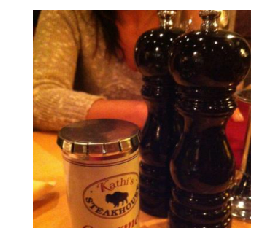

In [5]:
if MODE == 'TEST':
    train_image_tuple = loader_train.__iter__().next()
    train_image_tuple[0] = train_image_tuple[0].to(device=device, dtype=dtype)
    train_image_tuple[1] = train_image_tuple[0].to(device=device, dtype=dtype)
    train_image_tuple[2] = train_image_tuple[0].to(device=device, dtype=torch.int32)
    train_image_tuple[3] = train_image_tuple[0].to(device=device, dtype=torch.int32)
    print(train_image_tuple[0].dtype, train_image_tuple[1].dtype, train_image_tuple[2].dtype, train_image_tuple[3].dtype)
    print(train_image_tuple[0].size())
    train_image = train_image_tuple[0][3]
    print(type(train_image))
    print(train_image.size())
    plt.axis('off')
    plt.imshow(yelp_dataloader.deprocess(train_image.data.cpu()))
    plt.show()
    train_image_labels = train_image_tuple[1][3]
    imgs = train_image_tuple[0]

In [6]:
def get_cnn_features(imgs, cnn, layer_num, f=None):
    """
    Use the CNN to extract features from the input image x.

    Inputs:
    - imgs: A PyTorch Tensor of shape (N, C, H, W) holding a minibatch of images that
      will be fed to the CNN.
    - cnn: A PyTorch model that we will use to extract features.
    - layer_num: Integer showing the number of cnn layer from which image features are to be extracted.
      This number should be smaller than the number of layers in the cnn model

    Returns:
    - features: A PyTorch Tensor input image features extracted from layer_numusing the cnn model.
    """
    
    cnn.eval()
    for param in cnn.parameters():
        param.requires_grad = False
    if f is None:
        f = torch.nn.Sequential(*list(cnn.children())[:layer_num])
    features = f(imgs)
    return features    

In [8]:
resnet18 = models.resnet18(pretrained=True) # size = 224
resnet18 = resnet18.to(device=device, dtype=dtype)

In [12]:
vgg16 = models.vgg16(pretrained=True) # size = 224
vgg16 = vgg16.to(device=device, dtype=dtype)

In [20]:
if MODE == 'TEST':
    layer_num = 9
    print('Number of layers in CNN = %d' % len(list(resnet18.children())))
    resnet18_feats = get_cnn_features(imgs, resnet18, layer_num)
    print('Size of features in layer %d' % layer_num, resnet18_feats.size())
    out = resnet18(imgs)
    print('Output size = ', out.size())

Number of layers in CNN = 10
Size of features in layer 9 torch.Size([128, 512, 1, 1])
Output size =  torch.Size([128, 1000])


In [9]:
print(list(resnet18.children())[7])

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, mome

In [28]:
if MODE == 'TEST':
    layer_num = 9
    print('Number of layers in CNN = %d' % len(list(resnet18.children())))
    resnet18_feats = get_cnn_features(imgs, resnet18, layer_num)
    print('Size of features in layer %d' % layer_num, resnet18_feats.size())
    #out = resnet18(imgs)
    #print('Output size = ', out.size())

Number of layers in CNN = 10
Size of features in layer 9 torch.Size([128, 512])


In [15]:
if MODE == 'TEST':
    layer_num = 1
    print('Number of layers in CNN = %d' % len(list(vgg16.children())))
    vgg16_feats = get_cnn_features(imgs, vgg16, layer_num)
    print('Size of features in layer %d' % layer_num, vgg16_feats.size())
    out = vgg16(imgs)
    print('Output size = ', out.size())

In [16]:
if MODE == 'TEST':
    # Extract fc7 features
    layer_num = 1
    print('Number of layers in CNN = %d' % len(list(vgg16.children())))
    layer1 = list(vgg16.children())[:layer_num]
    layer1_feats = get_cnn_features(imgs, vgg16, layer_num)
    print('Size of features in layer %d' % layer_num, layer1_feats.size())
    layer2 = list(vgg16.classifier.children())[:4]
    f = torch.nn.Sequential(*layer2)
    N, _, _, _ = layer1_feats.size()
    layer1_feats = layer1_feats.view(N, -1)
    vgg16_feats = get_cnn_features(layer1_feats, vgg16, layer_num, f=f)
    print('Size of features of %s' % 'vgg16.fc7', vgg16_feats.size())
    #out = vgg16(imgs)
    #print('Output size = ', out.size())

In [17]:
def get_vgg16_fc7(vgg16, imgs):
    layer_num = 1
    layer1 = list(vgg16.children())[:layer_num]
    layer1_feats = get_cnn_features(imgs, vgg16, layer_num)
    layer2 = list(vgg16.classifier.children())[:4]
    f = torch.nn.Sequential(*layer2)
    N, _, _, _ = layer1_feats.size()
    layer1_feats = layer1_feats.view(N, -1)
    vgg16_feats = get_cnn_features(layer1_feats, vgg16, layer_num, f=f)
    return vgg16_feats
    

In [18]:
if MODE == 'TEST':
    vgg16_feats = get_vgg16_fc7(vgg16, imgs)
    print('Size of features of %s' % 'vgg16.fc7', vgg16_feats.size())

In [19]:
if MODE == 'TEST':
    print(len(train_image_tuple))
    print(type(train_image_tuple[0]))
    print(type(train_image_tuple[1]))
    print(type(train_image_tuple[2]))
    print(type(train_image_tuple[3]))
    print(train_image_tuple[0].size())
    print(train_image_tuple[1].size())
    print(train_image_tuple[2].size())
    print(train_image_tuple[3].size())

In [10]:
def write_yelp_to_h5(f, meta_feats, photo_feats):
    hf = h5py.File(f, 'w')
    hf.create_dataset('yelp_meta_feats', data=meta_feats)
    hf.create_dataset('yelp_photo_feats', data=photo_feats)
    hf.close()

In [11]:
def read_yelp_from_h5(dir, file_name, num_batches, num_feats):
    meta_feats = np.empty((0, 11), np.int32) # (photo_id, biz_id, l0, l1, ..., l8)
    photo_feats = np.empty((0, num_feats + 2), np.float32) # (photo_id, biz_id, 4096 fc7 features)
    for i in range(num_batches):
        file_path = os.path.join(dir, file_name + str(i) + '.h5')
        print(file_path)
        hf = h5py.File(file_path, 'r')
        meta_feats_batch = hf.get('yelp_meta_feats')
        meta_feats_batch = np.array(meta_feats_batch, dtype=np.int32)
        meta_feats = np.vstack((meta_feats, meta_feats_batch))
        photo_feats_batch = hf.get('yelp_photo_feats')
        photo_feats_batch = np.array(photo_feats_batch)
        photo_feats = np.vstack((photo_feats, photo_feats_batch))
            
    return meta_feats, photo_feats

In [ ]:
# Get inception feautures
feat_dir = '/home/Afshin/cs231n/cs231n-project/yelp-inception-feats'
file_counter = 0
num_feats = 2048
layer_num = 17
meta_feats = np.empty((0, 11), np.int32) # (photo_id, biz_id, l0, l1, ..., l8)
photo_feats = np.empty((0, num_feats + 2), np.float32) # (photo_id, biz_id, 512 features)
batch_counter = 0
start = timer()
for imgs, label_tensor, photo_id, biz_id in loader_train:
    imgs = imgs.to(device=device, dtype=dtype)
    label_tensor = label_tensor.to(device=device, dtype=dtype)
    photo_id = photo_id.to(device=device, dtype=torch.int32)
    biz_id = biz_id.to(device=device, dtype=torch.int32)
    
    photo_id_np = photo_id.cpu().numpy()
    photo_id_np = photo_id_np.reshape((photo_id_np.shape[0], 1))
    biz_id_np = biz_id.cpu().numpy()
    biz_id_np = biz_id_np.reshape(biz_id_np.shape[0], 1)
    meta_feats_app = np.hstack((photo_id_np, biz_id_np, label_tensor.cpu().numpy()))
    meta_feats = np.vstack((meta_feats, meta_feats_app))
    
    resnet_feats = get_cnn_features(imgs, inception, layer_num).squeeze()
    resnet_feats = np.hstack((photo_id_np, biz_id_np, inception_feats.cpu().data.numpy()))
    photo_feats = np.vstack((photo_feats, inception_feats))
    
    batch_counter += 1
    if photo_feats.shape[0] >= 50000:
        photo_feats_path = os.path.join(feat_dir, 'yelp_inception_' + str(file_counter) + '.h5')
        print(photo_feats_path)
        write_yelp_to_h5(photo_feats_path, meta_feats, photo_feats)
        meta_feats = np.empty((0, 11), np.int32) # (photo_id, biz_id, l0, l1, ..., l8)
        photo_feats = np.empty((0, num_feats + 2), np.float32) # (photo_id, biz_id, 2048 features)
        file_counter += 1

    if batch_counter % 200 == 0:
        end = timer()
        print('load time for %d batches = %f seconds.' % (batch_counter, (end - start)))

if photo_feats.shape[0] > 0:
    photo_feats_path = os.path.join(feat_dir, 'yelp_incception_' + str(file_counter) + '.h5')
    print(photo_feats_path)
    write_yelp_to_h5(photo_feats_path, meta_feats, photo_feats)
end = timer()
print('load time for %d batches = %f seconds.' % (batch_counter, (end - start)))
    

In [12]:
# Get resnet18 feautures
feat_dir = '/home/Afshin/cs231n/cs231n-project/yelp-resnet-feats'
file_counter = 0
num_feats = 512
meta_feats = np.empty((0, 11), np.int32) # (photo_id, biz_id, l0, l1, ..., l8)
photo_feats = np.empty((0, num_feats + 2), np.float32) # (photo_id, biz_id, 512 features)
batch_counter = 0
start = timer()
for imgs, label_tensor, photo_id, biz_id in loader_train:
    imgs = imgs.to(device=device, dtype=dtype)
    label_tensor = label_tensor.to(device=device, dtype=dtype)
    photo_id = photo_id.to(device=device, dtype=torch.int32)
    biz_id = biz_id.to(device=device, dtype=torch.int32)
    
    photo_id_np = photo_id.cpu().numpy()
    photo_id_np = photo_id_np.reshape((photo_id_np.shape[0], 1))
    biz_id_np = biz_id.cpu().numpy()
    biz_id_np = biz_id_np.reshape(biz_id_np.shape[0], 1)
    meta_feats_app = np.hstack((photo_id_np, biz_id_np, label_tensor.cpu().numpy()))
    meta_feats = np.vstack((meta_feats, meta_feats_app))
    
    resnet_feats = get_cnn_features(imgs, resnet18, 9).squeeze()
    resnet_feats = np.hstack((photo_id_np, biz_id_np, resnet_feats.cpu().data.numpy()))
    photo_feats = np.vstack((photo_feats, resnet_feats))
    
    batch_counter += 1
    if photo_feats.shape[0] >= 50000:
        photo_feats_path = os.path.join(feat_dir, 'yelp_resnet_' + str(file_counter) + '.h5')
        print(photo_feats_path)
        write_yelp_to_h5(photo_feats_path, meta_feats, photo_feats)
        meta_feats = np.empty((0, 11), np.int32) # (photo_id, biz_id, l0, l1, ..., l8)
        photo_feats = np.empty((0, num_feats + 2), np.float32) # (photo_id, biz_id, 512 features)
        file_counter += 1

    if batch_counter % 200 == 0:
        end = timer()
        print('load time for %d batches = %f seconds.' % (batch_counter, (end - start)))

if photo_feats.shape[0] > 0:
    photo_feats_path = os.path.join(feat_dir, 'yelp_resnet_' + str(file_counter) + '.h5')
    print(photo_feats_path)
    write_yelp_to_h5(photo_feats_path, meta_feats, photo_feats)
end = timer()
print('load time for %d batches = %f seconds.' % (batch_counter, (end - start)))
    

load time for 200 batches = 60.066416 seconds.
/home/Afshin/cs231n/cs231n-project/yelp-resnet-feats/yelp_resnet_0.h5
load time for 400 batches = 133.170345 seconds.
load time for 600 batches = 193.229007 seconds.
/home/Afshin/cs231n/cs231n-project/yelp-resnet-feats/yelp_resnet_1.h5
load time for 800 batches = 265.926221 seconds.
load time for 1000 batches = 327.237467 seconds.
/home/Afshin/cs231n/cs231n-project/yelp-resnet-feats/yelp_resnet_2.h5
load time for 1200 batches = 399.454913 seconds.
load time for 1400 batches = 560.219864 seconds.
/home/Afshin/cs231n/cs231n-project/yelp-resnet-feats/yelp_resnet_3.h5
load time for 1600 batches = 736.593125 seconds.
load time for 1800 batches = 913.999477 seconds.
/home/Afshin/cs231n/cs231n-project/yelp-resnet-feats/yelp_resnet_4.h5
load time for 1835 batches = 946.770625 seconds.


In [13]:
dir_path = '/home/Afshin/cs231n/cs231n-project/yelp-resnet-feats'
file_name = 'yelp_resnet_'
num_feats = 512
num_batches = 5
start = timer()
meta_feats, photo_feats = read_yelp_from_h5(dir_path, file_name, num_batches, num_feats)
end = timer()
print('load time for Yelp features.', (end - start))
print(meta_feats.shape)
print(photo_feats.shape)

/home/Afshin/cs231n/cs231n-project/yelp-resnet-feats/yelp_resnet_0.h5
/home/Afshin/cs231n/cs231n-project/yelp-resnet-feats/yelp_resnet_1.h5
/home/Afshin/cs231n/cs231n-project/yelp-resnet-feats/yelp_resnet_2.h5
/home/Afshin/cs231n/cs231n-project/yelp-resnet-feats/yelp_resnet_3.h5
/home/Afshin/cs231n/cs231n-project/yelp-resnet-feats/yelp_resnet_4.h5
load time for Yelp features. 3.397289752999768
(234842, 11)
(234842, 514)


In [22]:
# Get VGG16 fc7 feautures
feat_dir = '/home/Afshin/cs231n/cs231n-project/yelp-data-feats'
file_counter = 0
num_feats = 4096
meta_feats = np.empty((0, 11), np.int32) # (photo_id, biz_id, l0, l1, ..., l8)
photo_feats = np.empty((0, num_feats + 2), np.float32) # (photo_id, biz_id, 4096 fc7 features)
batch_counter = 0
start = timer()
for imgs, label_tensor, photo_id, biz_id in loader_train:
    imgs = imgs.to(device=device, dtype=dtype)
    label_tensor = label_tensor.to(device=device, dtype=dtype)
    photo_id = photo_id.to(device=device, dtype=torch.int32)
    biz_id = biz_id.to(device=device, dtype=torch.int32)
    
    photo_id_np = photo_id.cpu().numpy()
    photo_id_np = photo_id_np.reshape((photo_id_np.shape[0], 1))
    biz_id_np = biz_id.cpu().numpy()
    biz_id_np = biz_id_np.reshape(biz_id_np.shape[0], 1)
    meta_feats_app = np.hstack((photo_id_np, biz_id_np, label_tensor.cpu().numpy()))
    meta_feats = np.vstack((meta_feats, meta_feats_app))
    
    vgg16_feats = get_vgg16_fc7(vgg16, imgs)
    vgg16_feats = np.hstack((photo_id_np, biz_id_np, vgg16_feats.cpu().data.numpy()))
    photo_feats = np.vstack((photo_feats, vgg16_feats))
    
    batch_counter += 1
    if photo_feats.shape[0] >= 50000:
        photo_feats_path = os.path.join(feat_dir, 'yelp_vgg16_fc7_' + str(file_counter) + '.h5')
        print(photo_feats_path)
        write_yelp_to_h5(photo_feats_path, meta_feats, photo_feats)
        meta_feats = np.empty((0, 11), np.int32) # (photo_id, biz_id, l0, l1, ..., l8)
        photo_feats = np.empty((0, num_feats + 2), np.float32) # (photo_id, biz_id, 4096 fc7 features)
        file_counter += 1

    if batch_counter % 200 == 0:
        end = timer()
        print('load time for %d batches = %f seconds.' % (batch_counter, (end - start)))

if photo_feats.shape[0] > 0:
    photo_feats_path = os.path.join(feat_dir, 'yelp_vgg16_fc7_' + str(file_counter) + '.h5')
    print(photo_feats_path)
    write_yelp_to_h5(photo_feats_path, meta_feats, photo_feats)
end = timer()
print('load time for %d batches = %f seconds.' % (batch_counter, (end - start)))
    

load time for 200 batches = 333.437208 seconds.
/home/Afshin/cs231n/cs231n-project/yelp-data-feats/yelp_vgg16_fc7_0.h5
load time for 400 batches = 782.256345 seconds.
load time for 600 batches = 1122.315969 seconds.
/home/Afshin/cs231n/cs231n-project/yelp-data-feats/yelp_vgg16_fc7_1.h5
load time for 800 batches = 1566.197198 seconds.
load time for 1000 batches = 1912.861199 seconds.
/home/Afshin/cs231n/cs231n-project/yelp-data-feats/yelp_vgg16_fc7_2.h5
load time for 1200 batches = 2359.283372 seconds.
load time for 1400 batches = 2712.710285 seconds.
/home/Afshin/cs231n/cs231n-project/yelp-data-feats/yelp_vgg16_fc7_3.h5
load time for 1600 batches = 3153.660673 seconds.
load time for 1800 batches = 3509.425343 seconds.
/home/Afshin/cs231n/cs231n-project/yelp-data-feats/yelp_vgg16_fc7_4.h5
load time for 1835 batches = 3586.935613 seconds.


In [24]:
dir_path = '/home/Afshin/cs231n/cs231n-project/yelp-data-feats'
file_name = 'yelp_vgg16_fc7_'
num_feats = 4096
num_batches = 5
start = timer()
meta_feats, photo_feats = read_yelp_from_h5(dir_path, file_name, num_batches, num_feats)
end = timer()
print('load time for Yelp features.', (end - start))
print(meta_feats.shape)
print(photo_feats.shape)

/home/Afshin/cs231n/cs231n-project/yelp-data-feats/yelp_vgg16_fc7_0.h5
/home/Afshin/cs231n/cs231n-project/yelp-data-feats/yelp_vgg16_fc7_1.h5
/home/Afshin/cs231n/cs231n-project/yelp-data-feats/yelp_vgg16_fc7_2.h5
/home/Afshin/cs231n/cs231n-project/yelp-data-feats/yelp_vgg16_fc7_3.h5
/home/Afshin/cs231n/cs231n-project/yelp-data-feats/yelp_vgg16_fc7_4.h5
load time for Yelp features. 67.98434881799949
(234842, 11)
(234842, 4098)
